In [1]:
import tensornetwork as tn
import ocr_data

import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [] #[(5,5)] #[(3,3),(3,3),(3,3),(3,3),(3,3)]
conv_stride = [] #[(3,3)] #[(1,1),(2,2),(1,1),(2,2),(1,1)]
conv_outs = [] #[(4,)] #[(4,),(8,),(8,),(16,),(16,)]
conv_layers = len(conv_kernels)
hidden_shapes = []
hidden_layers = len(hidden_shapes)
recurrent_layers = 2
recurrent_size = 20
residual_layers = 0
more_hidden_shapes = []
more_hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(32, 32) (26,)


In [4]:
in_layer = tn.Input(input_shape)()
last_layer = in_layer
print(in_layer)
for kernel_shape,out_shape,kernel_stride in zip(conv_kernels,conv_outs,conv_stride):
    last_layer = tn.Conv(kernel_shape,out_shape=out_shape,kernel_stride=kernel_stride,pad=True,activation=tn.ReLU())(last_layer)
    print(last_layer)
for hidden_shape in hidden_shapes:
    last_layer = tn.Dense(hidden_shape,activation=tn.Tanh())(last_layer)
    print(last_layer)
for i in range(recurrent_layers):
    last_layer = tn.RNN(recurrent_size,activation=tn.Tanh())(last_layer)
    print(last_layer)
for i in range(residual_layers):
    last_layer = tn.ResWrap(tn.Dense(last_layer.output_shapes[0],activation=tn.Tanh()))(last_layer)
    print(last_layer)
for hidden_shape in more_hidden_shapes:
    last_layer = tn.Dense(hidden_shape,activation=tn.Tanh())(last_layer)
    print(last_layer)
out_layer = tn.Dense(output_shape,activation=tn.Sigmoid())(last_layer)
print(out_layer)

s = tn.System(inputs=[in_layer],outputs=[out_layer])

Input :: [] -> [(32, 32)]
Combine :: [(32, 20), (20,)] -> [(32, 20), (20,)]
Combine :: [(32, 20), (20,)] -> [(32, 20), (20,)]
Dense :: [(32, 20)] -> [(26,)]


In [5]:
import multiprocessing
import functools

def batch(length=1000):    
    total,failures = 0,0
    state = None
    for true_out,input in ocr_data.tagged_2d_data(length):
        guess_out,state = s.guess([input],return_state=True)
        #print(guess_out[0]-true_out)
        if np.argmax(guess_out[0]) != np.argmax(true_out):
            failures += 1
        s.learn(state,[true_out],method='adam',scale=0.0001,loss='quad')
        total += 1
    return total,failures

In [6]:
print('loading weights')
#s.load_weights('OCR_recurrent_network.h5')

loading weights


In [7]:
%prun batch(100)

In [ ]:
try:
    batch_size = 1000
    while True:
        cases,failures = batch(batch_size)
        print('saving weights')
        s.save_weights('OCR_recurrent_network.h5')
        print('batch accuracy',cases-failures,'/',cases)
        if (cases-failures)/cases > 0.999:
            break
except KeyboardInterrupt:
    print('Stopped by user')

neuron A


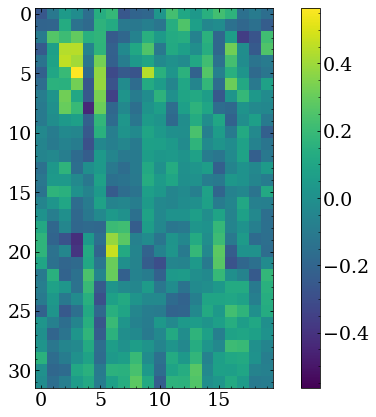

neuron B


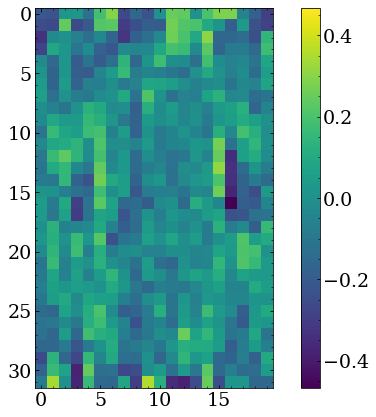

neuron C


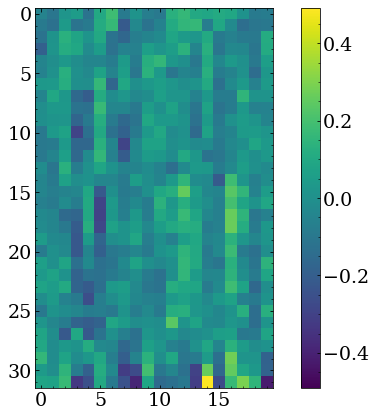

neuron D


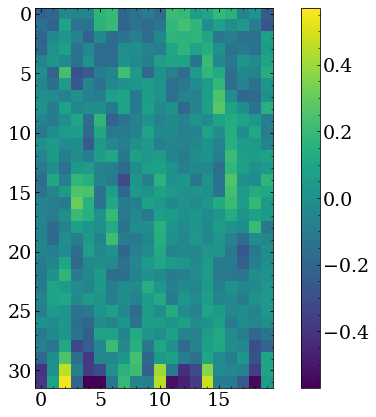

neuron E


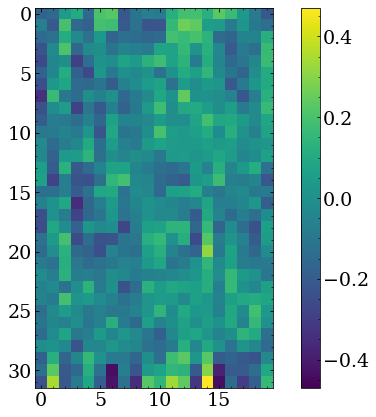

neuron F


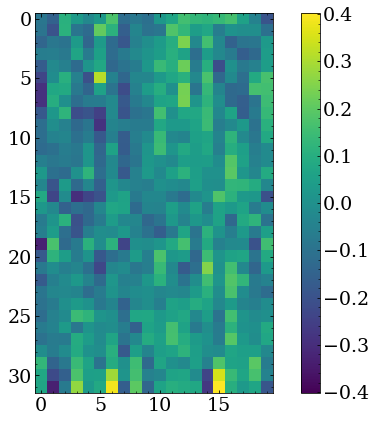

neuron G


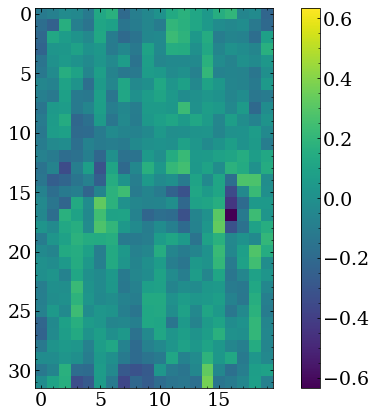

neuron H


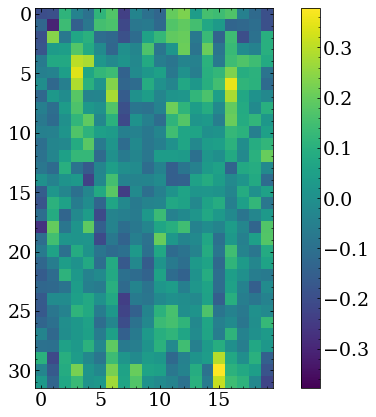

neuron I


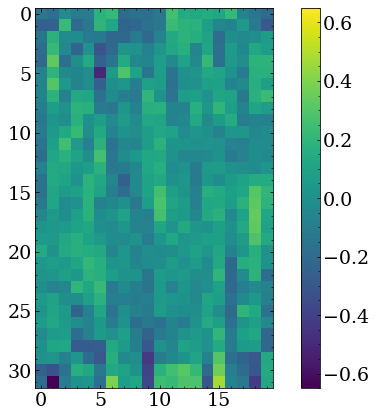

neuron J


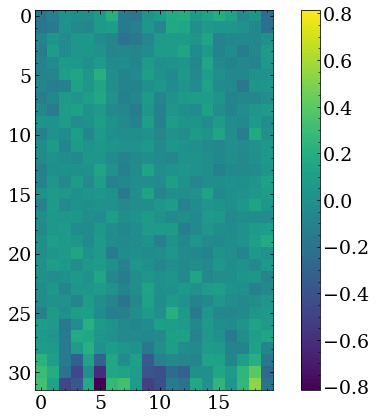

neuron K


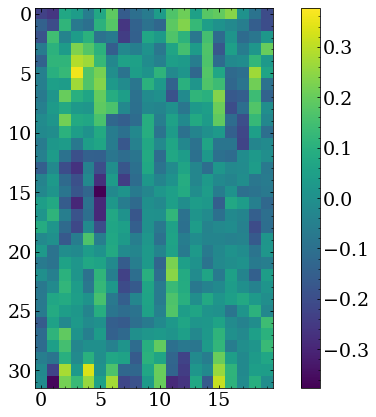

neuron L


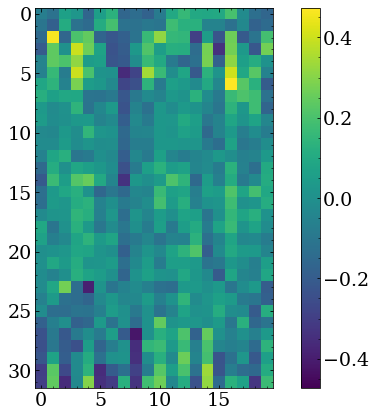

neuron M


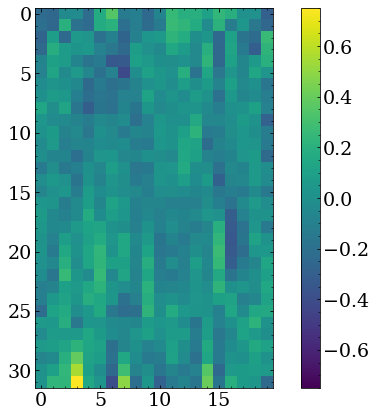

neuron N


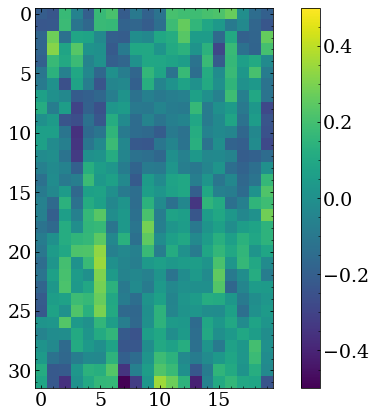

neuron O


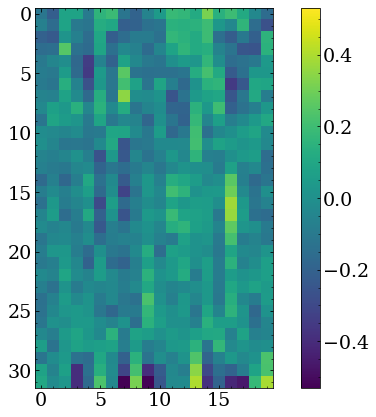

neuron P


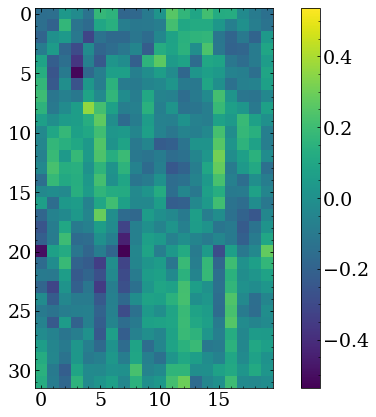

neuron Q


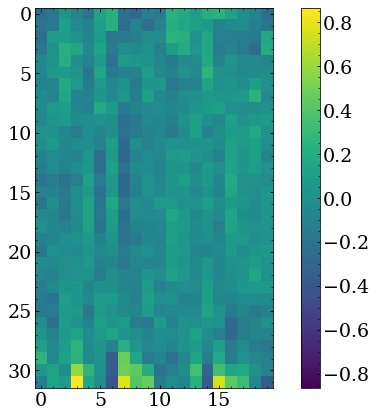

neuron R


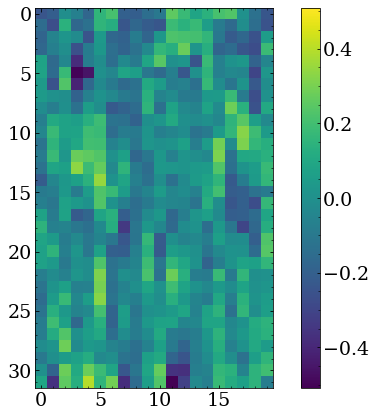

neuron S


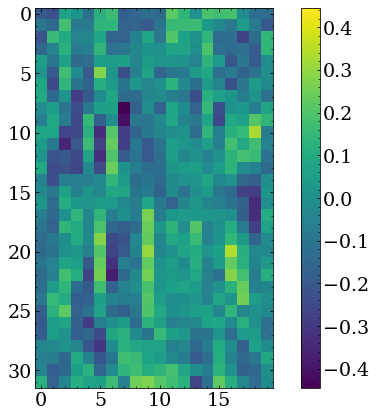

neuron T


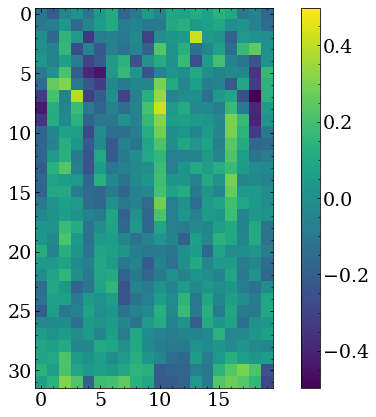

neuron U


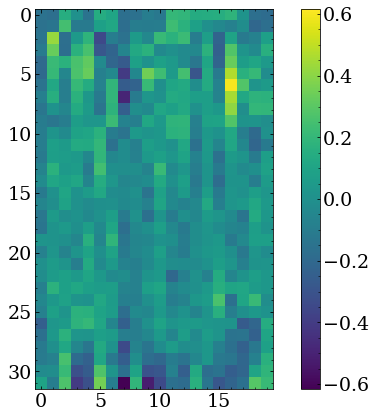

neuron V


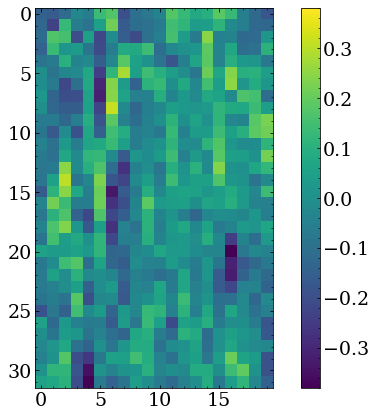

neuron W


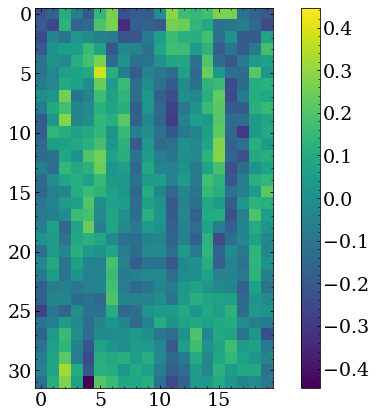

neuron X


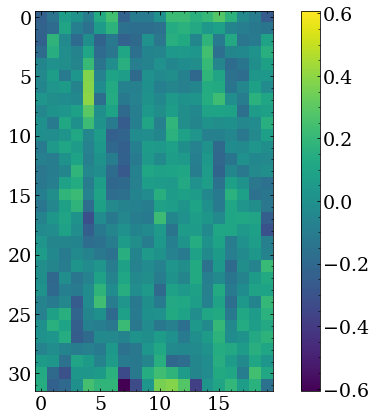

neuron Y


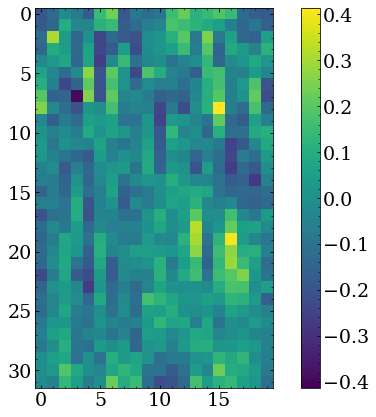

In [9]:
for i,c in enumerate(range(ord('A'),ord('Z'))):
    print('neuron',chr(c))
    data = s.parts[0].layer[0].weights[i,:].reshape((32,recurrent_size))
    norm = np.max(np.abs(data))
    plt.imshow(data,norm=matplotlib.colors.Normalize(-norm,norm))
    
    plt.colorbar()
    plt.show()
    plt.close()

Clone(Dense) :: [(40,)] -> [(20,)]
(20, 40)


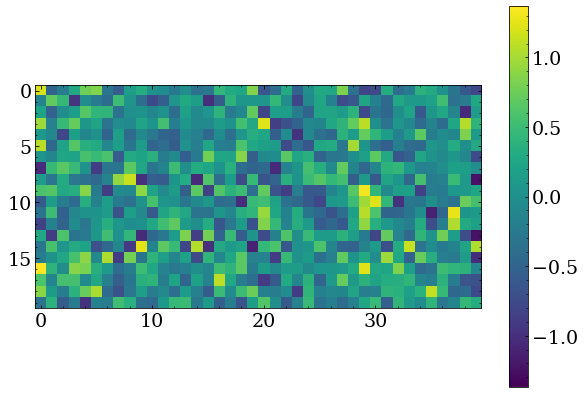

In [10]:
print(s.parts[3])
print(s.parts[3].layer[0].weights.shape)
data = s.parts[3].layer[0].weights.reshape((recurrent_size,recurrent_size+recurrent_size))
norm = np.max(np.abs(data))
plt.imshow(data,norm=matplotlib.colors.Normalize(-norm,norm))
plt.colorbar()
plt.show()
plt.close()

Clone(Dense) :: [(52,)] -> [(20,)]
(20, 52)


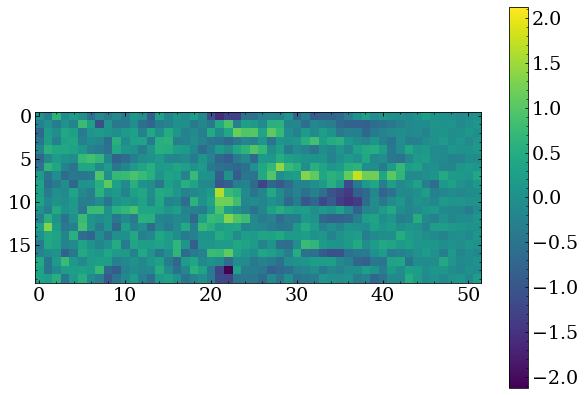

In [11]:
print(s.parts[100])
print(s.parts[100].layer[0].weights.shape)
data = s.parts[100].layer[0].weights.reshape((recurrent_size,recurrent_size+32))
norm = np.max(np.abs(data))
plt.imshow(data,norm=matplotlib.colors.Normalize(-norm,norm))
plt.colorbar()
plt.show()
plt.close()